# Projet 7 : Analyse de sentiment sur une base de données de tweets

## Plan  
* 1 modèle simple LogisticRegression
* 2 modele sur mesure CNN
    * 2.1 pretraitement optimal (aucun, simple, avancé, avancé et lemmatization)
    * 2.2 embedding optimal (aucun, glove, google)
* 3 modèle sur mesure BiLSTM

In [2]:
# Basic utilities
import os
import re
from string import punctuation
from collections import Counter, defaultdict

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm.auto import tqdm 


# Word embeddings
from gensim.models import Word2Vec,KeyedVectors

# Machine Learning
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,roc_auc_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM, Conv1D, GlobalMaxPooling1D, Dropout,SpatialDropout1D,Dense,\
                                    MaxPooling1D, TextVectorization, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from keras.backend import clear_session

# Experiment tracking
import mlflow
import mlflow.keras


# Natural Language Processing
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag

from datetime import datetime

import pickle
import json

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('words')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cecil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cecil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Cecil\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Cecil\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:

os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5000'


# Load and preprocess the custom dataset
def prepro_data(df, feat, label):
    
    # Recupere seulement n tweet
    df_positive = df[df[label] == 0].head(int(model_config['n_sample']/2))
    df_negative = df[df[label] == 1].head(int(model_config['n_sample']/2))
    df = pd.concat([df_positive, df_negative])
    
    
    # avant prepro
    for i in df[feat][0:3]:
        print(i+'\n')
        
    # prepro la colonne de tweets    
    df[feat] = df[feat].apply(lambda x: cleaner(x)) 
   
    # apres prepro    
    for i in df[feat][0:3]:
        print(i+'\n')
    
    
    x = df[feat]
    y = df[label]
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        train_size=0.8, 
                                                        shuffle=True,
                                                        stratify=y,
                                                        random_state=42,)
    
    
    print(f"x_train shape : {len(x_train)}")
    print(f"y_train shape : {len(y_train)}")
    print(f"x_test shape : {len(x_test)}")
    print(f"y_test shape : {len(y_test)}")
    
    return x_train, y_train, x_test, y_test

def cleaner(text) :     

    if model_config['preprocessing'] == 'simple' :
        
        text = text.lower()
        # tokenization 
        tokens = nltk.word_tokenize(text) 
        # remove puncs 
        punc = list(punctuation)
        tokens = [word for word in tokens if word not in punc]
        # remove stopwords 
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if  word not in stop_words]
        text = ' '.join(tokens)
        
    if model_config['preprocessing'] == 'advanced' :

            text = text.lower()

            text = re.sub('<.*?>', '', text) # HTML tags
            text = re.sub(r'\d+', '', text) # numbers
            text = re.sub(r'[^\w\s]', '', text) # special characters
            text = re.sub(r'http\S+', '', text) # URLs or web links
            text = re.sub(r'@\S+', '', text) # mentions
            text = re.sub(r'#\S+', '', text) # hashtags

            # tokenization 
            tokens = nltk.word_tokenize(text) 
            # remove puncs 
            punc = list(punctuation)
            tokens = [word for word in tokens if word not in punc]
            # remove stopwords 
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words]
            text = ' '.join(tokens)        
        
        
        
    if model_config['preprocessing'] == 'advanced_lemma' :
            
            text = text.lower()

            text = re.sub('<.*?>', '', text) # HTML tags
            text = re.sub(r'\d+', '', text) # numbers
            text = re.sub(r'[^\w\s]', '', text) # special characters
            text = re.sub(r'http\S+', '', text) # URLs or web links
            text = re.sub(r'@\S+', '', text) # mentions
            text = re.sub(r'#\S+', '', text) # hashtags

            # tokenization 
            tokens = nltk.word_tokenize(text) 
            # remove puncs 
            punc = list(punctuation)
            tokens = [word for word in tokens if word not in punc]
            # remove stopwords 
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if  word not in stop_words]
            
            lemmatizer = WordNetLemmatizer() 
            wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
            pos_tagged_text = pos_tag(tokens)
            l_lem = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]
            
            text = ' '.join(l_lem)
            
        
    return text




# Build the model
def build_model():    
    
    vectorizer = TextVectorization(max_tokens = 20000,
                                   output_sequence_length=200,
                                   output_mode ='int')
    
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    
    vectorizer.adapt(train_dataset)    
    voc = vectorizer.get_vocabulary()
    print(len(voc) + 2)
    
    VOCAB_SIZE = len(voc) + 2 
    EMBEDDING_DIM = 100
    
    current_date = datetime.now().strftime("%Y_%m_%d")

    # # Construire le nom du fichier
    # file_name = f"{current_date}_vectorizer.json"
    # 
    # with open(file_name, 'w') as f:
    #     json.dump({'config': vectorizer.get_config(),
    #                'weights': vectorizer.get_weights()}, f)
    
    print('Building model ...')

    [print(i,':\t',model_config[i]) for i in model_config]


    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    
    
    model.add(vectorizer)
    
    print(model_config['pre_trained_embeddings'])
    print( model_config['pre_trained_embeddings'] == 'glove200')
    
    if model_config['pre_trained_embeddings'] == 'aucun' :
        embedding_layer = Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        trainable=True)
        
    if model_config['pre_trained_embeddings'] == 'glove200' :      
        
        path_to_glove_file = "./glove.twitter.27B.200d.txt"

        embeddings_index = {}
        with open(path_to_glove_file, encoding='utf-8') as f:
            for line in f:
                word, coefs = line.split(maxsplit=1)
                coefs = np.fromstring(coefs, "f", sep=" ")
                embeddings_index[word] = coefs

        print("Loading %s word vectors from glove." % len(embeddings_index))

        display(len(vectorizer.get_vocabulary()))
        display(vectorizer.get_vocabulary()[:5])
        voc = vectorizer.get_vocabulary()
        word_index = dict(zip(voc, range(len(voc))))

        print(len(voc) + 2)
        VOCAB_SIZE = len(voc) + 2
        EMBEDDING_DIM = 200
        hits = 0
        misses = 0
        # Prepare embedding matrix
        embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in embedding index will be all-zeros.
                # This includes the representation for "padding" and "OOV"
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        print(f"Converted {hits} words ({misses} misses), {round(hits/(hits + misses) * 100)} %")
        

        
        embedding_layer = Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=True)

        
    if model_config['pre_trained_embeddings'] == 'google300' :

        word2vec_path = './GoogleNews-vectors-negative300.bin'  # Update the path to your downloaded model
        word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

        voc = vectorizer.get_vocabulary()
        word_index = dict(zip(voc, range(len(voc))))
        for i, (w, index) in enumerate(word_index.items()):
            if i < 5:
                print(w, index)
        # Constants
        VOCAB_SIZE = len(voc) + 2
        EMBEDDING_DIM = 300
        hits = 0
        misses = 0
        # Prepare embedding matrix
        embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
        for word, i in word_index.items():
            if word in word2vec_model:
                try:
                    embedding_vector = word2vec_model[word]
                    embedding_matrix[i] = embedding_vector
                    hits += 1
                except KeyError:
                    misses += 1
        print(f"Converted {hits} words ({misses} misses), {round(hits/(hits + misses) * 100)} %")


        embedding_layer = Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=True)
            
    model.add(embedding_layer)
   

    if model_config['model_type'] == 'CNN':
        model.add(Conv1D(128, 7, activation='relu', strides=3))
        model.add(Conv1D(128, 7, activation='relu', strides=3))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        
    if model_config['model_type'] == 'LSTM':
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))


    model.add(Dense(1, activation='sigmoid', name='predictions'))
    
    model.summary()    

    return model



# Compile the model
def compile_model(model):
    print('Compiling model ...')
    model.compile(optimizer=Adam(learning_rate=model_config['l_r']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Define the callbacks
# def get_callbacks():
#     early_stopping = EarlyStopping(monitor='val_loss',
#                                    patience=6,
#                                    verbose=1)
#     model_checkpoint = ModelCheckpoint('best_model.keras',
#                                        save_best_only=True,
#                                        monitor='val_loss',
#                                        verbose=1)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                                   factor=0.1,
#                                   patience=6,
#                                   verbose=1)
#     return [early_stopping, model_checkpoint, reduce_lr]

def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=4,
                                   verbose=1)
    model_checkpoint = ModelCheckpoint('best_model.keras',
                                       save_best_only=True,
                                       monitor='val_loss',
                                       verbose=1)
    return [early_stopping, model_checkpoint]

# Train the model
def train_eval_model(model, x_train, y_train, x_test, y_test):
    print('Start training ...')
    callbacks = get_callbacks()
    with mlflow.start_run(run_name=model_config['model_type']+'_'+model_config['preprocessing']+ \
                          '_'+model_config['pre_trained_embeddings']):
        clear_session()
        history = model.fit(x_train, y_train,
                            epochs=50,
                            batch_size=32,
                            validation_split=0.2,
                            callbacks=callbacks)
        
        pred_serie = pd.DataFrame(model.predict(x_test))
        y_pred = pred_serie.iloc[:,0].map(lambda x : 1 if x > 0.5 else 0)
        
        accuracy = round(accuracy_score(y_test, y_pred),4)
        auc = round(roc_auc_score(y_test, pred_serie),4) 
        
        mlflow.keras.log_model(model, "model")        
        mlflow.log_metric("Test Accuracy", accuracy)
        mlflow.log_metric("Test Auc", auc)
        mlflow.log_params(model_config)  # Log model configuration
    
        print("Test_Accuracy", accuracy)
        print("Test_Auc", auc)
        
    return history


# Plot accuracy and AUC
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    

# Chargement du dataset


In [4]:


dataset_filename = os.listdir("./input")[0]
dataset_path = os.path.join("./", "input", dataset_filename)
print("Open file:", dataset_path)

DATASET_COLUMNS = ["labels", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(dataset_path,
                 encoding=DATASET_ENCODING,
                 names=DATASET_COLUMNS)
df['labels'] = df['labels'].replace(4, 1)

print(df['labels'].unique())


Open file: ./input\tweet.csv
[0 1]


In [4]:
df.head()

,labels,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
x_train=['je mange bien', 'je mange beaucoup']
x_test=['je mange trop', 'je mange beaucoup']

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=10)
vectorizer.adapt(x_train)    

x_train_vec = vectorizer(x_train)
x_test_vec = vectorizer(x_test) 

In [10]:
x_train_vec

<tf.Tensor: shape=(2, 10), dtype=int64, numpy=
array([[3, 2, 4, 0, 0, 0, 0, 0, 0, 0],
       [3, 2, 5, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)>

In [11]:
x_test_vec

<tf.Tensor: shape=(2, 10), dtype=int64, numpy=
array([[3, 2, 1, 0, 0, 0, 0, 0, 0, 0],
       [3, 2, 5, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)>


# Modèles LR sklearn avec suivi mlflow

Dans cette partie, nous réalisons un modèle simple de régression logistique avec la library scikit-learn.
Nous réalisons un pipeline avec une extraction de feature via TF-IDF puis nous trouvons les meilleurs hyperparamètres grace à gridsearch.

x_train shape : (320000,)
y_train shape : (320000,)
x_test shape : (80000,)
y_test shape : (80000,)
model_type :	 LR
preprocessing :	 aucun
pre_trained_embeddings :	 None
n_sample :	 400000
l_r :	 -


1042580                     @Alicia_86 srry  u get my tweet?
1246955    @jchiarelli TTS to take text Tweets to the pho...
1585960                         Mmmm apple cinnomin oatmeal 
1312063    @willwallaceii thanks man. the truth can be fu...
1023142            RAIN   The plants and trees are happy ^~^
Name: text, dtype: object

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     40000
           1       0.79      0.80      0.80     40000

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



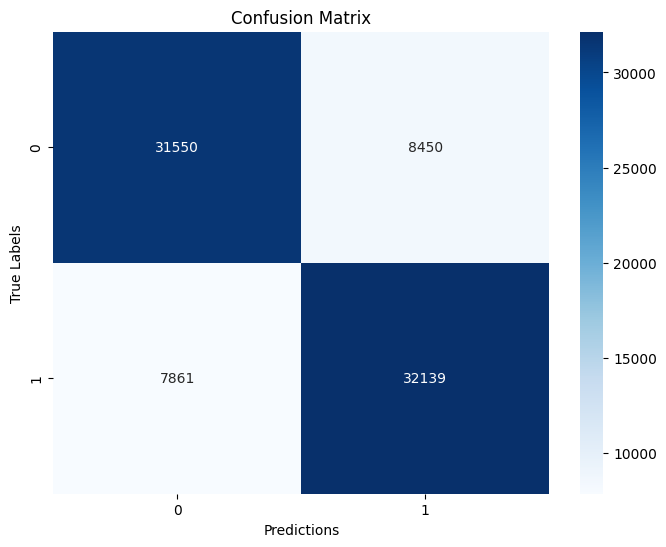

C:\anaconda\envs\7_sentiment\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model_config = {
                'model_type': 'LR',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "None",   
                'n_sample' : 400000,
                'l_r' : "-",
                }

x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                    df['labels'],
                                                    train_size=int(model_config['n_sample']*0.8),
                                                    test_size=int(model_config['n_sample']*0.2),
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=df['labels'])

print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"y_test shape : {y_test.shape}")

[print(i,':\t',model_config[i]) for i in model_config]



display(x_train.head())
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to TF-IDF vectors
    ('clf', LogisticRegression(max_iter=1000))  # Logistic Regression classifier
])

# Define the parameter grid
param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear']  # 'liblinear' is used for l1 and l2 penalties
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

with mlflow.start_run(run_name='LR_GridSearch') as run:

    # Perform grid search
    grid_search.fit(x_train, y_train)

    # Get the best parameters and estimator
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_estimator.predict(x_test)

    # Evaluate the model
    report = classification_report(y_test, y_pred)
    print(report)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=best_estimator.named_steps['clf'].classes_)

    # Display the confusion matrix with seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_estimator.named_steps['clf'].classes_, yticklabels=best_estimator.named_steps['clf'].classes_)
    plt.xlabel('Predictions')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute test accuracy
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, best_estimator.predict_proba(x_test)[:,1])
    
    mlflow.log_metric('Test Accuracy', acc)
    mlflow.log_metric('Test Accuracy', auc)
    
    mlflow.sklearn.log_model(best_estimator, "best_model")
        

# Modèles CNN avec suivi mlflow

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

x_train shape : 320000
y_train shape : 320000
x_test shape : 80000
y_test shape : 80000
20002
Building model ...
model_type :	 CNN
preprocessing :	 aucun
pre_trained_embeddings :	 aucun
n_sample :	 400000
l_r :	 5e-05
aucun
False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, 200)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 100)            │       2,000,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 65, 128)             │          89,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 128)             │         114,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,221,385 (8.47 MB)

 Trainable params: 2,221,385 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...

Epoch 1/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6641 - loss: 0.5850
Epoch 1: val_loss improved from inf to 0.44628, saving model to best_model.keras
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 250s 31ms/step - accuracy: 0.6641 - loss: 0.5850 - val_accuracy: 0.7933 - val_loss: 0.4463
Epoch 2/50
7999/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8051 - loss: 0.4287
Epoch 2: val_loss improved from 0.44628 to 0.43771, saving model to best_model.keras
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 244s 30ms/step - accuracy: 0.8051 - loss: 0.4287 - val_accuracy: 0.7974 - val_loss: 0.4377
Epoch 3/50
7999/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8197 - loss: 0.4038
Epoch 3: val_loss improved from 0.43771 to 0.43600, saving model to best_model.keras
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 250s 31ms/step - accuracy: 0.8197 - loss: 0.4038 - val_accuracy: 0.7981 - val_loss: 0.4360
Epoch 4/50
7999/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8310 - 

2024/08/10 20:55:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Test_Accuracy 0.7806
Test_Auc 0.8614


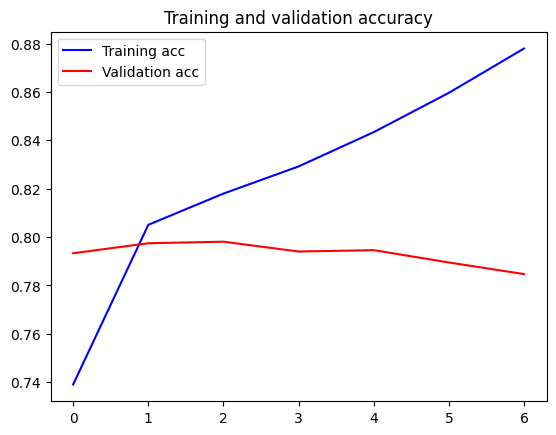

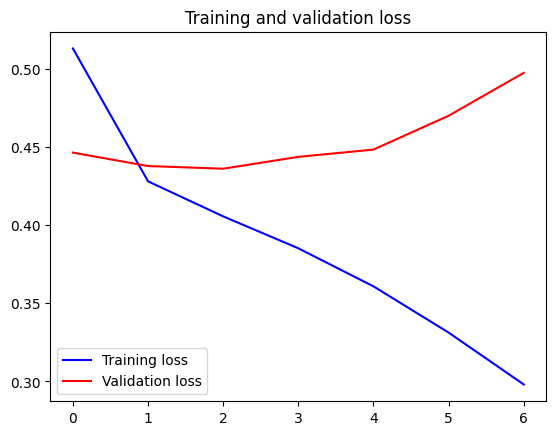

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

switchfoot http //twitpic.com/2y1zl awww 's bummer shoulda got david carr third day

upset ca n't update facebook texting ... might cry result school today also blah

kenichan dived many times ball managed save 50 rest go bounds

x_train shape : 320000
y_train shape : 320000
x_test shape : 80000
y_test shape : 80000
20002
Building model ...
model_type :	 CNN
preprocessing :	 simple
pre_trained_embeddings :	 aucun
n_sample :	 400000
l_r :	 5e-05
aucun
False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 200)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 100)            │       2,000,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 65, 128)             │          89,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 128)             │         114,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,221,385 (8.47 MB)

 Trainable params: 2,221,385 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6428 - loss: 0.6005
Epoch 1: val_loss improved from inf to 0.47192, saving model to best_model.keras
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 239s 30ms/step - accuracy: 0.6428 - loss: 0.6005 - val_accuracy: 0.7749 - val_loss: 0.4719
Epoch 2/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7923 - loss: 0.4500
Epoch 2: val_loss improved from 0.47192 to 0.46238, saving model to best_model.keras
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 236s 29ms/step - accuracy: 0.7923 - loss: 0.4500 - val_accuracy: 0.7791 - val_loss: 0.4624
Epoch 3/50
7950/8000 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8076 - loss: 0.4217

In [13]:
%%time
# Constants
MAXLEN = 200
VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 50
# liste des choix possibles : 

# model_config = {
# 'model_type': 'CNN','LSTM',
# 'preprocessing': 'aucun', 'simple','advanced', 'advanced_lemma',
# 'metrics': ['accuracy', 'auc'],
# 'embeddings' :  "./glove.twitter.27B.[25,50,200]d.txt", ""./GoogleNews-vectors-negative300.bin"
# 'n_sample' : 400000,O
# }






model_config = {
                'model_type': 'CNN',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "aucun",   
                'n_sample' : 400000,
                'l_r' : 0.00005,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)
conf_matrix = confusion_matrix(y_test, y_pred, labels=best_estimator.named_steps['clf'].classes_)

# Display the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_estimator.named_steps['clf'].classes_, yticklabels=best_estimator.named_steps['clf'].classes_)
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
    
    
model_config = {
                'model_type': 'CNN',
                'preprocessing': 'simple',
                'pre_trained_embeddings' :  "aucun",   
                'n_sample' : 400000,
                'l_r' : 0.00005,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)

model_config = {
                'model_type': 'CNN',
                'preprocessing': 'advanced',
                'pre_trained_embeddings' :  "aucun",   
                'n_sample' : 400000,
                'l_r' : 0.00005,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)

model_config = {
                'model_type': 'CNN',
                'preprocessing': 'advanced_lemma',
                'pre_trained_embeddings' :  "aucun",   
                'n_sample' : 400000,
                'l_r' : 0.00005,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)


# Modele pré entrainé avec "glove.twitter.27B.200d.txt"

source : https://keras.io/examples/nlp/pretrained_word_embeddings/

In [14]:
%%time 

# model_config = {
#                 'model_type': 'CNN',
#                 'preprocessing': 'advanced_lemma',
#                 'pre_trained_embeddings' :  "glove_200",   
#                 'n_sample' : 400000,
#                 'l_r' : 0.0001,
#                 }
# 
# 
# path_to_glove_file = "./glove.twitter.27B.200d.txt"
# 
# embeddings_index = {}
# with open(path_to_glove_file, encoding='utf-8') as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         embeddings_index[word] = coefs
# 
# print("Loading %s word vectors from glove." % len(embeddings_index))


# vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
# 
# # Nous récupérons seulement x_train au format str pour creer le vocabulaire d'embedding sur la partie train et ne pas 
# # réaliser de dataleakage par apprentissage de données test qui seraient induites par vectorizer.adapt(df[text])
# x_train, x_test, y_train, y_test = train_test_split(df['text'],
#                                                     df['labels'],
#                                                     train_size=int(model_config['n_sample']*0.8),
#                                                     test_size=int(model_config['n_sample']*0.2),
#                                                     shuffle=True,
#                                                     stratify=df['labels'],
#                                                     random_state=42,)
# display(x_train.iloc[0])
# x_train = x_train.apply(DataPrep)
# display(x_train.iloc[0])
# 
# text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
# vectorizer.adapt(text_ds)
# display(len(vectorizer.get_vocabulary()))
# display(vectorizer.get_vocabulary()[:5])
# 
# voc = vectorizer.get_vocabulary()
# word_index = dict(zip(voc, range(len(voc))))
# 
# 
# 
# 
# print(len(voc) + 2)
# EMBEDDING_DIM = 200
# 
# 
# hits = 0
# misses = 0
# # Prepare embedding matrix
# embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # Words not found in embedding index will be all-zeros.
#         # This includes the representation for "padding" and "OOV"
#         embedding_matrix[i] = embedding_vector
#         hits += 1
#     else:
#         misses += 1
# print(f"Converted {hits} words ({misses} misses), {round(hits/(hits + misses) * 100)} %")

model_config = {
                'model_type': 'CNN',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "glove200",   
                'n_sample' : 400000,
                'l_r' : 0.0001,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)

# Modele pré entrainé avec "GoogleNews-vectors-negative300.bin"

In [15]:
%%time 

# model_config = {
#                 'model_type': 'CNN',
#                 'preprocessing': 'simple',
#                 'metrics': ['accuracy', 'auc'],
#                 'pre_trained_embeddings' :  "google300",
#                 'n_sample' : 400000,
#                 'l_r' : 0.0001,
#                 }
# # Load Google News Word2Vec embeddings
# 
# word2vec_path = './GoogleNews-vectors-negative300.bin'  # Update the path to your downloaded model
# word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
# 
# # transforme des phrases en array de int et retourne le vocabulary
# vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
# 
# # Nous récupérons seulement x_train au format str pour creer le vocabulaire d'embedding sur la partie train et ne pas 
# # réaliser de dataleakage par apprentissage de données test qui seraient induites par vectorizer.adapt(df[text])
# x_train, x_test, y_train, y_test = train_test_split(df['text'],
#                                                     df['labels'],
#                                                     train_size=int(model_config['n_sample']*0.8),
#                                                     test_size=int(model_config['n_sample']*0.2),
#                                                     shuffle=True,
#                                                     stratify=df['labels'],
#                                                     random_state=42,)
# display(len(vectorizer.get_vocabulary()))
# text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
# vectorizer.adapt(text_ds)
# 
# 
# display(len(vectorizer.get_vocabulary()))
# display(vectorizer.get_vocabulary()[:5])
# 
# voc = vectorizer.get_vocabulary()
# word_index = dict(zip(voc, range(len(voc))))
# 
# for i, (w, index) in enumerate(word_index.items()):
#     if i < 5:
#         print(w, index)
# 
# # Constants
# VOCAB_SIZE = len(voc) + 2
# EMBEDDING_DIM = 300
# 
# 
# hits = 0
# misses = 0
# # Prepare embedding matrix
# embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
# for word, i in word_index.items():
#     if word in word2vec_model:
#         try:
#             embedding_vector = word2vec_model[word]
#             embedding_matrix[i] = embedding_vector
#             hits += 1
#         except KeyError:
#             misses += 1
# print(f"Converted {hits} words ({misses} misses), {round(hits/(hits + misses) * 100)} %")
# 
# 
# 
# x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
# model = build_model()
# compile_model(model)
# history = train_eval_model(model, x_train, y_train, x_test, y_test)
# plot_metrics(history)
model_config = {
                'model_type': 'CNN',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "google300",   
                'n_sample' : 400000,
                'l_r' : 0.0001,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)


# Modèle LSTM bidirectionnel sans pre trained embedding

source : https://keras.io/examples/nlp/bidirectional_lstm_imdb/

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

x_train shape : 320000
y_train shape : 320000
x_test shape : 80000
y_test shape : 80000
20002
Building model ...
model_type :	 LSTM
preprocessing :	 aucun
pre_trained_embeddings :	 aucun
n_sample :	 400000
l_r :	 5e-05
aucun
False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 200)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 100)            │       2,000,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,183,625 (8.33 MB)

 Trainable params: 2,183,625 (8.33 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7040 - loss: 0.5532
Epoch 1: val_loss improved from inf to 0.45232, saving model to best_model.keras
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 2305s 288ms/step - accuracy: 0.7040 - loss: 0.5532 - val_accuracy: 0.7895 - val_loss: 0.4523
Epoch 2/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8035 - loss: 0.4318
Epoch 2: val_loss improved from 0.45232 to 0.44772, saving model to best_model.keras
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 1763s 220ms/step - accuracy: 0.8035 - loss: 0.4318 - val_accuracy: 0.7911 - val_loss: 0.4477
Epoch 3/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8128 - loss: 0.4144
Epoch 3: val_loss improved from 0.44772 to 0.44198, saving model to best_model.keras
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 1897s 237ms/step - accuracy: 0.8128 - loss: 0.4144 - val_accuracy: 0.7940 - val_loss: 0.4420
Epoch 4/50
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 

2024/08/11 18:23:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 236s 94ms/step
Test_Accuracy 0.7924
Test_Auc 0.8742


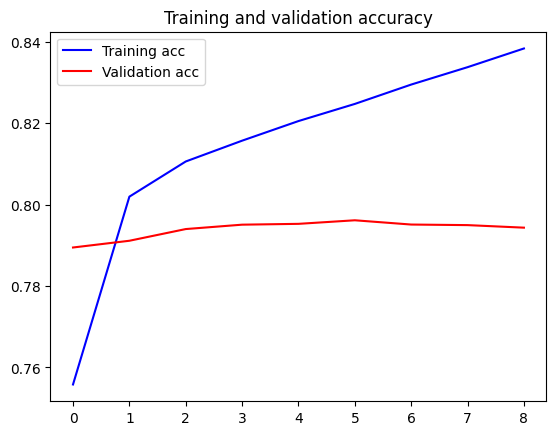

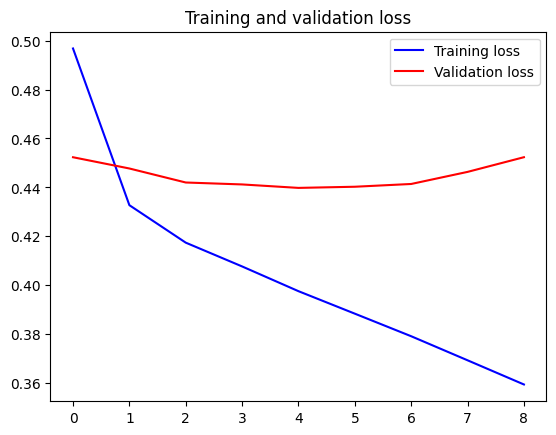

CPU times: total: 2h 5min 18s
Wall time: 5h 55min 9s


In [23]:
%%time

# # Load Google News Word2Vec embeddings
# 
# word2vec_path = './GoogleNews-vectors-negative300.bin'  # Update the path to your downloaded model
# word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
# 
# # transforme des phrases en array de int et creer le vocabulary
# vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
# 
# # Nous récupérons seulement x_train au format str pour creer le vocabulaire d'embedding sur la partie train et ne pas 
# # réaliser de dataleakage par apprentissage de données test qui seraient induites par vectorizer.adapt(df[text])
# x_train, x_test, y_train, y_test = train_test_split(df['text'],
#                                                     df['labels'],
#                                                     train_size=int(model_config['n_sample']*0.8),
#                                                     test_size=int(model_config['n_sample']*0.2),
#                                                     shuffle=True,
#                                                     stratify=df['labels'],
#                                                     random_state=42,)
# text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
# vectorizer.adapt(text_ds)
# 
# display(len(vectorizer.get_vocabulary()))
# display(vectorizer.get_vocabulary()[:5])
# 
# voc = vectorizer.get_vocabulary()
# word_index = dict(zip(voc, range(len(voc))))
# 
# for i, (w, index) in enumerate(word_index.items()):
#     if i < 5:
#         print(w, index)
# 
# # Constants

# hits = 0
# misses = 0
# # Prepare embedding matrix
# embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
# for word, i in word_index.items():
#     if word in word2vec_model:
#         try:
#             embedding_vector = word2vec_model[word]
#             embedding_matrix[i] = embedding_vector
#             hits += 1
#         except KeyError:
#             misses += 1
# print("Converted %d words (%d misses)" % (hits, misses))

model_config = {
                'model_type': 'LSTM',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "aucun",
                'n_sample' : 400000,
                'l_r' : 0.00005,
                }
x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)




# essai avec hugging face

In [6]:
ds_train

Dataset({
    features: ['labels', 'text'],
    num_rows: 64000
})

In [7]:
ds_test

Dataset({
    features: ['labels', 'text'],
    num_rows: 16000
})

In [7]:
from transformers import AutoTokenizer

import evaluate
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

from datasets import Dataset, load_dataset

model_config = {
                'model_type': 'BERT',
                'preprocessing': "google_bert_bert_base_cased",
                'pre_trained_embeddings' :  "aucun",
                'n_sample' : 80000,
                'l_r' : 0.00005,
                }

df_sample = df.sample(n=model_config['n_sample'], random_state=42)

df_sample = df_sample[['labels','text']]

df_sample_train, df_sample_test = train_test_split(df_sample, test_size=0.2, random_state=42)

ds_train = Dataset.from_pandas(df_sample_train,preserve_index=False)
ds_test = Dataset.from_pandas(df_sample_test,preserve_index=False)

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

# def compute_custom_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     
#     accuracy = accuracy_score(labels, preds)
#     area = roc_auc_score(labels, preds)
# 
#     
#     return {
#         'Test Accuracy': accuracy,
#         'Test Auc': area,
# 
#     }


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


small_train_dataset = ds_train.map(tokenize_function, batched=True)
small_train_dataset = small_train_dataset.class_encode_column("labels")
small_eval_dataset = ds_test.map(tokenize_function, batched=True)
small_eval_dataset = small_eval_dataset.class_encode_column("labels")


model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=2)


training_args = TrainingArguments(learning_rate=model_config['l_r'],
                                  output_dir="test_trainer")

os.environ['DISABLE_MLFLOW_INTEGRATION'] = 'TRUE'


# training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch",logging_steps=150)
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset    
)

with mlflow.start_run(run_name=model_config['model_type'] + '_' + model_config['preprocessing'] + '_' + model_config['pre_trained_embeddings']):

  #  trainer.train(resume_from_checkpoint="test_trainer/checkpoint-13000")
    trainer.train()    

    
    # Evaluate the model
    # results = trainer.evaluate(small_eval_dataset)
    
    predictions = trainer.predict(small_eval_dataset)
    y_pred = predictions.predictions.argmax(-1)
    predicted_probs = tf.math.softmax(predictions.predictions, axis=-1)    
    
    # Calculate sklearn metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, predicted_probs[:, 1])

    # Log metrics
    mlflow.pytorch.log_model(model, "model")        
    mlflow.log_metric("Test Accuracy", accuracy)
    mlflow.log_metric("Test Auc", auc)
    mlflow.log_params(model_config)  # Log model configuration







Map:   0%|          | 0/64000 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/64000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/64000 [00:00<?, ? examples/s]

ArrowMemoryError: realloc of size 268435456 failed

# essai avec huggin for tensorflow

Incompatibilité avec les bibliothèques de metrics keras. Seul 'accuracy' fonctionne. 'auc' ne fonctionne pas tf.keras.metrics.AUC() non plus.

In [5]:
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import TFAutoModelForSequenceClassification

import tensorflow as tf

import evaluate

from datasets import Dataset, load_dataset

import keras

model_config = {
                'model_type': 'BERTtf',
                'preprocessing': "google-bert/bert-base-cased",
                'pre_trained_embeddings' :  "aucun",
                'n_sample' : 200000,
                'l_r' : 0.00003,
                }

df_sample = df.sample(n=model_config['n_sample'], random_state=42)

df_sample = df_sample[['labels','text']]

df_sample_train, df_sample_test = train_test_split(df_sample, test_size=0.2, random_state=42)

ds_train = Dataset.from_pandas(df_sample_train,preserve_index=False)
ds_test = Dataset.from_pandas(df_sample_test,preserve_index=False)

tokenizer = AutoTokenizer.from_pretrained(model_config['preprocessing'])

tokenized_data_train = tokenizer(ds_train["text"], return_tensors="np", padding=True)
tokenized_data_train = dict(tokenized_data_train)

tokenized_data_test = tokenizer(ds_test["text"], return_tensors="np", padding=True)
tokenized_data_test = dict(tokenized_data_test)

y_train = np.array(ds_train["labels"])  # Label is already an array of 0 and 1
y_test = np.array(ds_test["labels"])  # Label is already an array of 0 and 1

# Load and compile our model
with mlflow.start_run(run_name=model_config['model_type'] + '_' + model_config['preprocessing'] + '_' + model_config['pre_trained_embeddings']):

    model = TFAutoModelForSequenceClassification.from_pretrained(model_config['preprocessing'])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=model_config['l_r']),
                  metrics=['accuracy'])
    model.fit(tokenized_data_train, y_train)

    # Make predictions on the test data
    predictions = model.predict(tokenized_data_test)
    
    # Convert predictions to probabilities and classes
    predicted_probs = tf.nn.softmax(predictions.logits, axis=-1)
    y_pred = tf.argmax(predicted_probs, axis=1).numpy()
    
    display(y_test)
    display(y_pred)
    display(predicted_probs)
    # Calculate sklearn metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, predicted_probs[:, 1])

    # Log metrics
    mlflow.keras.log_model(model, "model")        
    mlflow.log_metric("Test Accuracy", accuracy)
    mlflow.log_metric("Test Auc", auc)
    mlflow.log_params(model_config)  # Log model configuration


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




   3/5000 [..............................] - ETA: 139:56:23 - loss: 0.7048 - accuracy: 0.4896

KeyboardInterrupt: 